In [125]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sn
from numpy import array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

Task 1 of Project 3.  Fully Connected Neural Network.

In [126]:
def run_task_1(training_images, testing_images, training_labels, testing_labels):
    #Construct network model
    task1_model = Sequential()
    task1_model.add(layers.Dense(units=1024,input_shape=(1024,), activation='tanh'))
    task1_model.add(layers.Dense(units=512, activation='sigmoid'))
    task1_model.add(layers.Dense(units=100, activation='relu'))
    task1_model.add(layers.Dense(units=2, activation='softmax'))
    
    #Create and fit the one hot encoder
    enc = OneHotEncoder(handle_unknown='ignore',sparse=False)
    encoded_training_labels = enc.fit_transform(training_labels)
    encoded_testing_labels = enc.fit_transform(testing_labels)
     
    #Create and fit the scaler to the data
    scaler = MinMaxScaler()
    scaled_training_images=scaler.fit_transform(training_images)
    scaled_testing_images=scaler.transform(testing_images)
    
    task1_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
    task1_model.fit(x=scaled_training_images,y=encoded_training_labels, epochs=15, validation_split=0.2)
    
    cm = task1_model.predict(x=scaled_testing_images)
    
    #call model.evaluate for the final test loss and final test accuracy
    test_scores = task1_model.evaluate(x=scaled_testing_images, y=encoded_testing_labels, verbose=2)
    print("Test loss:", test_scores[0])
    print("Test accuracy:", test_scores[1])
    

    print(len(cm))
    sn.heatmap(cm, annot=False)
    
    return task1_model

Epoch 1/15
25/25 [==============================] - 1s 14ms/step - loss: 0.7092 - accuracy: 0.4900 - val_loss: 0.6898 - val_accuracy: 0.5200
Epoch 2/15
25/25 [==============================] - 0s 9ms/step - loss: 0.6911 - accuracy: 0.5250 - val_loss: 0.6877 - val_accuracy: 0.5350
Epoch 3/15
25/25 [==============================] - 0s 10ms/step - loss: 0.6848 - accuracy: 0.5263 - val_loss: 0.6930 - val_accuracy: 0.5050
Epoch 4/15
25/25 [==============================] - 0s 11ms/step - loss: 0.6869 - accuracy: 0.5663 - val_loss: 0.6829 - val_accuracy: 0.5550
Epoch 5/15
25/25 [==============================] - 0s 11ms/step - loss: 0.6749 - accuracy: 0.6000 - val_loss: 0.6902 - val_accuracy: 0.5300
Epoch 6/15
25/25 [==============================] - 0s 11ms/step - loss: 0.6676 - accuracy: 0.5738 - val_loss: 0.7006 - val_accuracy: 0.5350
Epoch 7/15
25/25 [==============================] - 0s 11ms/step - loss: 0.6819 - accuracy: 0.5612 - val_loss: 0.6731 - val_accuracy: 0.6050
Epoch 8/15
25/

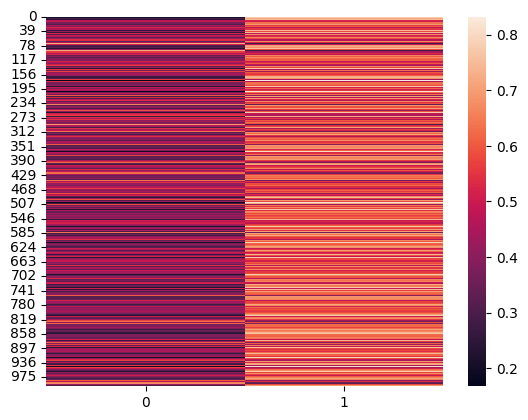

In [127]:
#read in training and testing csv with labels for our data
training_labels = pd.read_csv('fairface_label_train.csv', nrows=1000)
training_labels=training_labels.drop('file',axis=1) 
training_labels=training_labels.drop('service_test',axis=1)
training_labels=training_labels.drop('age',axis=1)
#training_labels=training_labels.drop('gender', axis=1)
training_labels=training_labels.drop('race',axis=1)

testing_labels = pd.read_csv('fairface_label_val.csv', nrows=1000)
testing_labels=testing_labels.drop('file',axis=1) 
testing_labels=testing_labels.drop('service_test',axis=1)
testing_labels=testing_labels.drop('age',axis=1)
#testing_labels=testing_labels.drop('gender', axis=1)
testing_labels=testing_labels.drop('race',axis=1)

#read in images that we will be predicting on
training_images = np.empty(shape=(1000,1024))
for i in range(1, 1001):
    f_string = 'train/' + str(i) + '.jpg'
    im = Image.open(f_string)
    im = np.array(im)
    im = im.flatten()
    training_images[i-1]=im
    
testing_images = np.empty(shape=(1000,1024))
for i in range(1, 1001):
    f_string = 'val/' + str(i) + '.jpg'
    im = Image.open(f_string)
    im = np.array(im)
    im = im.flatten()
    testing_images[i-1]=im
    
mod = run_task_1(training_images=training_images, testing_images=testing_images, training_labels=training_labels, testing_labels=testing_labels)

Task 2 of Project 3.   Small Convolutional Neural Network.

In [128]:
def run_task_2(training_images, testing_images, training_labels, testing_labels):
    #build the network
    task2_model = Sequential()
    task2_model.add(layers.Conv2D(filters=40, kernel_size=(5,5), activation='relu', 
                                  strides=1, padding='valid', input_shape=(32,32,1)))
    task2_model.add(layers.MaxPooling2D(pool_size=(2,2)))
    task2_model.add(layers.Flatten())
    task2_model.add(layers.Dense(units=100, activation='relu'))
    task2_model.add(layers.Dense(units=2, activation='softmax'))
    
    #Create and fit the one hot encoder
    enc = OneHotEncoder(handle_unknown='ignore',sparse=False)
    encoded_training_labels = enc.fit_transform(training_labels)
    encoded_testing_labels = enc.fit_transform(testing_labels)
    
    #scale the training and testing data sets using a model fit to the training set
    min_max_scalar = MinMaxScaler()
    for i in range(0, len(training_images)):
        training_images[i] = min_max_scalar.fit_transform(training_images[i])
    for i in range(0, len(testing_images)):
        testing_images[i] = min_max_scalar.transform(testing_images[i])
        
    task2_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
    task2_model.fit(x=training_images,y=encoded_training_labels, epochs=15, validation_split=0.2)
    
    cm = task2_model.predict(x=testing_images)
    
    test_scores = task2_model.evaluate(x=testing_images, y=encoded_testing_labels, verbose=2)
    print("Test loss:", test_scores[0])
    print("Test accuracy:", test_scores[1])
    
    print(len(cm))
    sn.heatmap(cm, annot=False)
    

Epoch 1/15
25/25 [==============================] - 2s 41ms/step - loss: 0.6942 - accuracy: 0.5088 - val_loss: 0.6912 - val_accuracy: 0.5300
Epoch 2/15
25/25 [==============================] - 1s 20ms/step - loss: 0.6856 - accuracy: 0.5587 - val_loss: 0.6856 - val_accuracy: 0.5550
Epoch 3/15
25/25 [==============================] - 1s 21ms/step - loss: 0.6781 - accuracy: 0.5875 - val_loss: 0.6831 - val_accuracy: 0.5600
Epoch 4/15
25/25 [==============================] - 1s 20ms/step - loss: 0.6755 - accuracy: 0.5875 - val_loss: 0.6804 - val_accuracy: 0.5550
Epoch 5/15
25/25 [==============================] - 1s 20ms/step - loss: 0.6698 - accuracy: 0.6112 - val_loss: 0.6908 - val_accuracy: 0.5250
Epoch 6/15
25/25 [==============================] - 0s 20ms/step - loss: 0.6658 - accuracy: 0.5962 - val_loss: 0.6762 - val_accuracy: 0.5950
Epoch 7/15
25/25 [==============================] - 0s 19ms/step - loss: 0.6625 - accuracy: 0.6237 - val_loss: 0.6741 - val_accuracy: 0.5700
Epoch 8/15
25

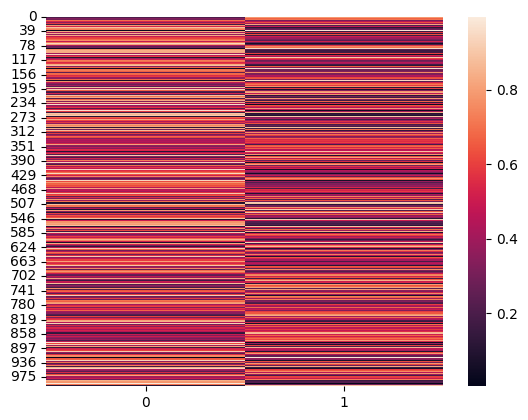

In [129]:
#read in training labels
training_labels=pd.read_csv('fairface_label_train.csv', nrows=1000)
training_labels=training_labels.drop('file',axis=1) 
training_labels=training_labels.drop('service_test',axis=1)
training_labels=training_labels.drop('age',axis=1)
#training_labels=training_labels.drop('gender', axis=1)
training_labels=training_labels.drop('race',axis=1)

testing_labels = pd.read_csv('fairface_label_val.csv', nrows=1000)
testing_labels=testing_labels.drop('file',axis=1) 
testing_labels=testing_labels.drop('service_test',axis=1)
testing_labels=testing_labels.drop('age',axis=1)
#testing_labels=testing_labels.drop('gender', axis=1)
testing_labels=testing_labels.drop('race',axis=1)

#read in images
training_images = np.empty(shape=(1000,32,32))
for i in range(1, 1001):
    f_string = 'train/' + str(i) + '.jpg'
    im = Image.open(f_string)
    im = np.array(im)
    training_images[i-1]=im
    
testing_images = np.empty(shape=(1000,32,32))
for i in range(1, 1001):
    f_string = 'val/' + str(i) + '.jpg'
    im = Image.open(f_string)
    im = np.array(im)
    testing_images[i-1]=im

mod_2 = run_task_2(training_images=training_images, testing_images=testing_images, training_labels=training_labels, testing_labels=testing_labels)

Task 3 of Project 3.  Create our own convolutional layer.

In [130]:
def run_task_3(training_images, testing_images, training_labels, testing_labels):
    #build the network
    task3_model = Sequential()
    task3_model.add(layers.Conv2D(filters=40, kernel_size=(5,5), activation='relu', 
                                  strides=1, padding='valid', input_shape=(32,32,1)))
    task3_model.add(layers.MaxPooling2D(pool_size=(2,2)))
    task3_model.add(layers.Conv2D(filters=20, kernel_size=(5,5), activation='relu', 
                                  strides=1, padding='valid', input_shape=(32,32,1)))
    task3_model.add(layers.MaxPooling2D(pool_size=(2,2)))
    task3_model.add(layers.Flatten())
    task3_model.add(layers.Dense(units=100, activation='relu'))
    task3_model.add(layers.Dense(units=2, activation='softmax'))
    
    #Create and fit the one hot encoder
    enc = OneHotEncoder(handle_unknown='ignore',sparse=False)
    encoded_training_labels = enc.fit_transform(training_labels)
    encoded_testing_labels = enc.fit_transform(testing_labels)
    
    #scale the training and testing data sets using a model fit to the training set
    min_max_scalar = MinMaxScaler()
    for i in range(0, len(training_images)):
        training_images[i] = min_max_scalar.fit_transform(training_images[i])
    for i in range(0, len(testing_images)):
        testing_images[i] = min_max_scalar.transform(testing_images[i])
        
    task3_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
    task3_model.fit(x=training_images,y=encoded_training_labels, epochs=15, validation_split=0.2)
    
    cm = task3_model.predict(x=testing_images)
    
    test_scores = task3_model.evaluate(x=testing_images, y=encoded_testing_labels, verbose=2)
    print("Test loss:", test_scores[0])
    print("Test accuracy:", test_scores[1])
    
    print(len(cm))
    sn.heatmap(cm, annot=False)

Epoch 1/15
25/25 [==============================] - 2s 47ms/step - loss: 0.6909 - accuracy: 0.5275 - val_loss: 0.6907 - val_accuracy: 0.5450
Epoch 2/15
25/25 [==============================] - 1s 31ms/step - loss: 0.6890 - accuracy: 0.5350 - val_loss: 0.6902 - val_accuracy: 0.5500
Epoch 3/15
25/25 [==============================] - 1s 26ms/step - loss: 0.6877 - accuracy: 0.5362 - val_loss: 0.6899 - val_accuracy: 0.5450
Epoch 4/15
25/25 [==============================] - 1s 26ms/step - loss: 0.6859 - accuracy: 0.5412 - val_loss: 0.6900 - val_accuracy: 0.5500
Epoch 5/15
25/25 [==============================] - 1s 27ms/step - loss: 0.6844 - accuracy: 0.5738 - val_loss: 0.6895 - val_accuracy: 0.5400
Epoch 6/15
25/25 [==============================] - 1s 25ms/step - loss: 0.6829 - accuracy: 0.6037 - val_loss: 0.6885 - val_accuracy: 0.5300
Epoch 7/15
25/25 [==============================] - 1s 25ms/step - loss: 0.6815 - accuracy: 0.5925 - val_loss: 0.6879 - val_accuracy: 0.5300
Epoch 8/15
25

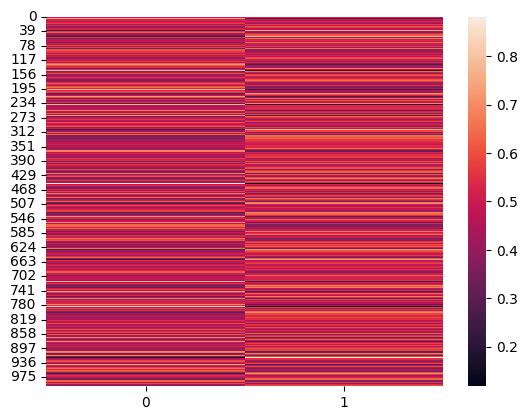

In [131]:
#read in training labels
training_labels=pd.read_csv('fairface_label_train.csv', nrows=1000)
training_labels=training_labels.drop('file',axis=1) 
training_labels=training_labels.drop('service_test',axis=1)
training_labels=training_labels.drop('age',axis=1)
#training_labels=training_labels.drop('gender', axis=1)
training_labels=training_labels.drop('race',axis=1)

testing_labels = pd.read_csv('fairface_label_val.csv', nrows=1000)
testing_labels=testing_labels.drop('file',axis=1) 
testing_labels=testing_labels.drop('service_test',axis=1)
testing_labels=testing_labels.drop('age',axis=1)
#testing_labels=testing_labels.drop('gender', axis=1)
testing_labels=testing_labels.drop('race',axis=1)

#read in images
training_images = np.empty(shape=(1000,32,32))
for i in range(1, 1001):
    f_string = 'train/' + str(i) + '.jpg'
    im = Image.open(f_string)
    im = np.array(im)
    training_images[i-1]=im
    
testing_images = np.empty(shape=(1000,32,32))
for i in range(1, 1001):
    f_string = 'val/' + str(i) + '.jpg'
    im = Image.open(f_string)
    im = np.array(im)
    testing_images[i-1]=im

mod_3 = run_task_3(training_images=training_images, testing_images=testing_images, training_labels=training_labels, testing_labels=testing_labels)

Task 4 of Project 3.  Create Your Own Convolutional Neural Network On Both Tasks Simultaneously.

In [132]:
def run_task_4(training_images, testing_images, training_labels, testing_labels):
    #build the network
    x = layers.Input(shape=(32,32,1))
    hidden1 = layers.Conv2D(filters=40, kernel_size=(5,5), activation='relu', 
                                  strides=1, padding='valid', input_shape=(32,32,1))(x)
    hidden2 = layers.MaxPooling2D(pool_size=(2,2))(hidden1)
    hidden3 = layers.Flatten()(hidden2)
    hidden_branch4 = layers.Dense(units=100, activation='relu')(hidden3)
    output1 = layers.Dense(units=2, activation='softmax')(hidden_branch4)
    hidden_branch5 = layers.Dense(units=100, activation='relu')(hidden3)
    output2 = layers.Dense(units=7, activation='softmax', )(hidden_branch5)
    task4_model = Model(inputs=x, outputs=[output1,output2])
    

    #scale the training and testing data sets using a model fit to the training set
    min_max_scalar = MinMaxScaler()
    for i in range(0, len(training_images)):
        training_images[i] = min_max_scalar.fit_transform(training_images[i])
    for i in range(0, len(testing_images)):
        testing_images[i] = min_max_scalar.fit_transform(testing_images[i])
    
    #Create and fit the one hot encoder
    enc = OneHotEncoder(handle_unknown='ignore',sparse=False)
    encoded_training_labels_gender = enc.fit_transform(training_labels[0])
    encoded_training_labels_race = enc.fit_transform(training_labels[1])
    
    encoded_testing_labels_gender = enc.fit_transform(testing_labels[0])
    encoded_testing_labels_race = enc.fit_transform(testing_labels[1])

    task4_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
    task4_model.fit(x=training_images,y=[encoded_training_labels_gender,encoded_training_labels_race], epochs=5, validation_split=0.2)
    cm = task4_model.predict(x=testing_images)
    
    test_scores = task4_model.evaluate(x=testing_images, y=[encoded_testing_labels_gender, encoded_testing_labels_race],verbose=2)
    print("Test loss:", test_scores[0])
    print("Test accuracy:", test_scores[1])
    
    print(len(cm))
    sn.heatmap(cm[1], annot=False)

Epoch 1/5
25/25 [==============================] - 2s 36ms/step - loss: 2.6238 - dense_225_loss: 0.6927 - dense_227_loss: 1.9310 - dense_225_accuracy: 0.5175 - dense_227_accuracy: 0.1775 - val_loss: 2.6248 - val_dense_225_loss: 0.6848 - val_dense_227_loss: 1.9400 - val_dense_225_accuracy: 0.5450 - val_dense_227_accuracy: 0.1750
Epoch 2/5
25/25 [==============================] - 1s 22ms/step - loss: 2.5996 - dense_225_loss: 0.6848 - dense_227_loss: 1.9148 - dense_225_accuracy: 0.5462 - dense_227_accuracy: 0.2025 - val_loss: 2.6083 - val_dense_225_loss: 0.6828 - val_dense_227_loss: 1.9255 - val_dense_225_accuracy: 0.5600 - val_dense_227_accuracy: 0.1750
Epoch 3/5
25/25 [==============================] - 1s 24ms/step - loss: 2.5815 - dense_225_loss: 0.6755 - dense_227_loss: 1.9060 - dense_225_accuracy: 0.6012 - dense_227_accuracy: 0.2138 - val_loss: 2.6024 - val_dense_225_loss: 0.6793 - val_dense_227_loss: 1.9231 - val_dense_225_accuracy: 0.5700 - val_dense_227_accuracy: 0.1750
Epoch 4/5


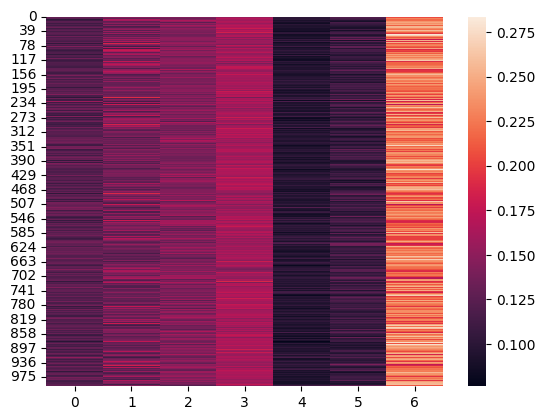

In [133]:
#read in training labels
training_labels=pd.read_csv('fairface_label_train.csv', nrows=1000)
training_labels=training_labels.drop('file',axis=1) 
training_labels=training_labels.drop('service_test',axis=1)
training_labels=training_labels.drop('age',axis=1)
#training_labels=training_labels.drop('gender', axis=1)
training_labels=training_labels.drop('race',axis=1)
gender_train_labels=training_labels


training_labels=pd.read_csv('fairface_label_train.csv', nrows=1000)
training_labels=training_labels.drop('file',axis=1) 
training_labels=training_labels.drop('service_test',axis=1)
training_labels=training_labels.drop('age',axis=1)
training_labels=training_labels.drop('gender', axis=1)
#training_labels=training_labels.drop('race',axis=1)
race_train_labels=training_labels

train_labels=[gender_train_labels, race_train_labels]

testing_labels = pd.read_csv('fairface_label_val.csv', nrows=1000)
testing_labels=testing_labels.drop('file',axis=1) 
testing_labels=testing_labels.drop('service_test',axis=1)
testing_labels=testing_labels.drop('age',axis=1)
#testing_labels=testing_labels.drop('gender', axis=1)
testing_labels=testing_labels.drop('race',axis=1)
gender_test_labels=testing_labels


testing_labels = pd.read_csv('fairface_label_val.csv', nrows=1000)
testing_labels=testing_labels.drop('file',axis=1) 
testing_labels=testing_labels.drop('service_test',axis=1)
testing_labels=testing_labels.drop('age',axis=1)
testing_labels=testing_labels.drop('gender', axis=1)
#testing_labels=testing_labels.drop('race',axis=1)
race_test_labels=testing_labels

test_labels=[gender_test_labels, race_test_labels]

#read in images
training_images = np.empty(shape=(1000,32,32))
for i in range(1, 1001):
    f_string = 'train/' + str(i) + '.jpg'
    im = Image.open(f_string)
    im = np.array(im)
    training_images[i-1]=im
    
testing_images = np.empty(shape=(1000,32,32))
for i in range(1, 1001):
    f_string = 'val/' + str(i) + '.jpg'
    im = Image.open(f_string)
    im = np.array(im)
    testing_images[i-1]=im

mod_4 = run_task_4(training_images=training_images, testing_images=testing_images, training_labels=train_labels, testing_labels=test_labels)